In [266]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [217]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [218]:
df = pd.read_csv("/content/gurgaon_properties_cleaned_v1.csv")

In [219]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,ireo victory valley,sector 67,2.95,12110.0,2436.0,Super Built up area 2436(226.31 sq.m.)Built Up...,3,3,3+,"servant room,pooja room",14.0,South,5 to 10 Year Old,"['AIPL Joy Street Mall', 'Golf Course Extensio...","['3 Wardrobe', '15 Fan', '1 Exhaust Fan', '5 G...","['Water purifier', 'Centrally Air Conditioned'..."


In [220]:
df[['area','areaWithType']].sample(5)

,area,areaWithType
3383,1326.0,Carpet area: 1326 (123.19 sq.m.)
412,1120.0,Super Built up area 1120(104.05 sq.m.)
219,1081.0,Super Built up area 1081(100.43 sq.m.)
938,7000.0,Built Up area: 7000 (650.32 sq.m.)
531,1130.0,Built Up area: 1130 (104.98 sq.m.)


In [221]:
# areaWithType -> Super Built Up, Plot Area, Carpet Area
# \d+: Matches one or more digits.
# \.?: Optionally matches a decimal point.
# \d*: Matches zero or more digits following the decimal point.


import re
# Function to extract the super built up area-
def get_super_built_up_area(text):
  match = re.search(r'Super Built up area (\d+\.?\d*)',text)
  if match:
    return float(match.group(1))
  return np.NaN

In [222]:
# Function to extract the carpet area or built up area
def get_area(text, area_type):
  match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)',text)
  if match:
    return match.group(1)
  return np.NaN

In [223]:
# Function to check if the area is provided in sq.m and convert it to sq.ft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return np.NaN
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

In [224]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [225]:
df['built_up_area']= df['built_up_area'].astype('float')
df['carpet_area']= df['carpet_area'].astype('float')

In [226]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)


,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1851,1.10,flat,1103.0,Built Up area: 1103 (102.47 sq.m.),NaN,1102.976833,NaN
1191,2.85,flat,2606.0,Super Built up area 2606(242.11 sq.m.)Carpet a...,2606.0,NaN,1800.0
2528,12.50,house,2430.0,Plot area 270(225.75 sq.m.),NaN,NaN,NaN
2866,1.10,flat,915.0,Built Up area: 915 (85.01 sq.m.)Carpet area: 7...,NaN,915.039139,700.0
2469,0.86,flat,1578.0,Super Built up area 1578(146.6 sq.m.)Carpet ar...,1578.0,NaN,1310.0


In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3803 entries, 0 to 3802
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        3803 non-null   object 
 1   society              3802 non-null   object 
 2   sector               3803 non-null   object 
 3   price                3785 non-null   float64
 4   price_per_sqft       3785 non-null   float64
 5   area                 3785 non-null   float64
 6   areaWithType         3803 non-null   object 
 7   bedRoom              3803 non-null   int64  
 8   bathroom             3803 non-null   int64  
 9   balcony              3803 non-null   object 
 10  additionalRoom       3803 non-null   object 
 11  floorNum             3784 non-null   float64
 12  facing               2698 non-null   object 
 13  agePossession        3802 non-null   object 
 14  nearbyLocations      3626 non-null   object 
 15  furnishDetails       2822 non-null   o

In [228]:
# rows where all the three area values are present
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
0,2.9500,flat,2436.0,Super Built up area 2436(226.31 sq.m.)Built Up...,2436.0,2236.00,2036.00
12,1.1500,flat,1000.0,Super Built up area 1450(134.71 sq.m.)Built Up...,1450.0,1400.00,1000.00
13,1.6700,flat,2191.0,Super Built up area 2191(203.55 sq.m.)Built Up...,2191.0,2091.00,1991.00
15,1.0500,flat,1400.0,Super Built up area 1755(163.04 sq.m.)Built Up...,1755.0,1600.00,1400.00
22,0.9500,flat,1445.0,Super Built up area 1445(134.24 sq.m.)Built Up...,1445.0,1300.00,1200.00
33,2.2500,flat,2092.0,Super Built up area 2092(194.35 sq.m.)Built Up...,2092.0,2090.00,2087.00
39,2.6100,flat,2598.0,Super Built up area 2598(241.36 sq.m.)Built Up...,2598.0,2200.00,2000.00
40,4.2500,flat,3763.0,Super Built up area 3763(349.59 sq.m.)Built Up...,3763.0,3000.00,2800.00
53,1.9500,flat,1350.0,Super Built up area 2191(203.55 sq.m.)Built Up...,2191.0,1650.00,1350.00
55,1.2000,flat,2000.0,Super Built up area 2000(185.81 sq.m.)Built Up...,2000.0,1900.00,1850.00


In [229]:
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape

(534, 7)

In [230]:
# Rows containing plot area
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,5.5000,house,1440.0,Plot area 160(133.78 sq.m.),NaN,NaN,NaN
2,NaN,house,NaN,Plot area 350(292.64 sq.m.)Built Up area: 6500...,NaN,6500.0,NaN
10,6.5000,house,2500.0,Plot area 2500(232.26 sq.m.),NaN,NaN,NaN
16,6.2500,house,9001.0,Plot area 1000(836.13 sq.m.),NaN,NaN,NaN
19,2.9000,house,1557.0,Plot area 173(144.65 sq.m.)Built Up area: 1415...,NaN,1415.0,1350.0
32,10.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,NaN,NaN
34,0.2700,house,225.0,Plot area 225(20.9 sq.m.),NaN,NaN,NaN
36,8.7000,house,2250.0,Plot area 250(209.03 sq.m.)Built Up area: 267 ...,NaN,267.0,NaN
43,10.0000,house,3600.0,Plot area 400(334.45 sq.m.),NaN,NaN,NaN
44,7.0000,house,7000.0,Plot area 350(32.52 sq.m.)Built Up area: 7000 ...,NaN,7000.0,NaN


In [231]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [232]:
# rows where all the three area values are present
all_nan_df = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]

In [233]:
all_nan_index = df[(df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull())][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index

In [234]:
# Function to extract plot area
def extract_plot_area(area_with_type):
  match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
  return float(match.group(1)) if match else np.NaN

In [235]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

In [236]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,5.5000,house,1440.0,Plot area 160(133.78 sq.m.),NaN,160.00,NaN
10,6.5000,house,2500.0,Plot area 2500(232.26 sq.m.),NaN,2500.00,NaN
16,6.2500,house,9001.0,Plot area 1000(836.13 sq.m.),NaN,1000.00,NaN
32,10.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
34,0.2700,house,225.0,Plot area 225(20.9 sq.m.),NaN,225.00,NaN
43,10.0000,house,3600.0,Plot area 400(334.45 sq.m.),NaN,400.00,NaN
47,2.0000,house,1440.0,Plot area 160(133.78 sq.m.),NaN,160.00,NaN
49,8.5000,house,4770.0,Plot area 530(443.15 sq.m.),NaN,530.00,NaN
63,8.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
74,8.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN


In [237]:
def convert_scale(row):
  if np.isnan(row['area']) or np.isnan(row['built_up_area']):
    return row['built_up_area']
  else:
    if round(row['area']/row['built_up_area']) == 9.0: # sq/yards
      return row['built_up_area'] * 9
    elif round(row['area']/row['built_up_area']) == 11.0: # sq/mt
      return row['built_up_area'] * 10.7
    else:
      return row['built_up_area']

In [238]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [239]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1,5.5000,house,1440.0,Plot area 160(133.78 sq.m.),NaN,1440.00,NaN
10,6.5000,house,2500.0,Plot area 2500(232.26 sq.m.),NaN,2500.00,NaN
16,6.2500,house,9001.0,Plot area 1000(836.13 sq.m.),NaN,9000.00,NaN
32,10.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
34,0.2700,house,225.0,Plot area 225(20.9 sq.m.),NaN,225.00,NaN
43,10.0000,house,3600.0,Plot area 400(334.45 sq.m.),NaN,3600.00,NaN
47,2.0000,house,1440.0,Plot area 160(133.78 sq.m.),NaN,1440.00,NaN
49,8.5000,house,4770.0,Plot area 530(443.15 sq.m.),NaN,4770.00,NaN
63,8.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN
74,8.5000,house,3240.0,Plot area 360(301.01 sq.m.),NaN,3240.00,NaN


In [240]:
# upadte the original dataframe
df.update(all_nan_df)

In [241]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [242]:
# additional rooms
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
store room                                         99
study room,servant room                            99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
pooja room,st

In [243]:
new_cols = ['study room','servant room','store room','pooja room', 'others']
for col in new_cols:
  df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [244]:
df.sample(5)[['additionalRoom','study room','servant room','store room','pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
2247,"pooja room,study room,servant room,others",1,1,0,1,1
647,"pooja room,servant room",0,1,0,1,0
1426,not available,0,0,0,0,0
1895,servant room,0,1,0,0,0
547,servant room,0,1,0,0,0


In [245]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,ireo victory valley,sector 67,2.95,12110.0,2436.0,Super Built up area 2436(226.31 sq.m.)Built Up...,3,3,3+,"servant room,pooja room",14.0,South,5 to 10 Year Old,"['AIPL Joy Street Mall', 'Golf Course Extensio...","['3 Wardrobe', '15 Fan', '1 Exhaust Fan', '5 G...","['Water purifier', 'Centrally Air Conditioned'...",2436.0,2236.000000,2036.000000,0,1,0,1,0
1,house,independent,sector 54,5.50,38194.0,1440.0,Plot area 160(133.78 sq.m.),18,18,3+,servant room,4.0,South-West,1 to 5 Year Old,"['Sector 54 chowk metro station', 'Sector metr...","['1 Water Purifier', '22 Fan', '1 Fridge', '1 ...","['Feng Shui / Vaastu Compliant', 'High Ceiling...",NaN,1440.000000,NaN,0,1,0,0,0
2,house,emaar mgf marbella,sector 66,NaN,NaN,NaN,Plot area 350(292.64 sq.m.)Built Up area: 6500...,4,4,3+,"pooja room,study room,servant room,store room",3.0,North,0 to 1 Year Old,"['Sector 55-56 Rapid Metro Station', 'HUB 66',...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,6500.000000,NaN,1,1,1,1,0
3,house,sobha city,sector 108,10.50,14323.0,7331.0,Built Up area: 7331 (681.07 sq.m.),5,4,3+,not available,1.0,East,undefined,"['Dwarka Sector 21', 'Dwarka Expressway', 'Vas...",NaN,NaN,NaN,7330.969373,NaN,0,0,0,0,0
4,flat,signature global grand iva,sector 103,0.30,8290.0,362.0,Carpet area: 361.88 (33.62 sq.m.),1,2,2,not available,5.0,NaN,0 to 1 Year Old,"['Dwaraka Expy, Tikampur Village', 'Sector 108...",[],"['Security / Fire Alarm', 'Lift(s)', 'Maintena...",NaN,NaN,361.882318,0,0,0,0,0


In [246]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old        1676
5 to 10 Year Old        575
0 to 1 Year Old         530
undefined               332
10+ Year Old            310
Under Construction       90
Within 6 months          70
Within 3 months          26
2023-12-01 00:00:00      22
By 2023                  19
By 2024                  17
2024-12-01 00:00:00      16
2024-03-01 00:00:00      14
2024-01-01 00:00:00       8
2024-10-01 00:00:00       8
2024-06-01 00:00:00       7
2023-08-01 00:00:00       7
2025-12-01 00:00:00       7
2023-11-01 00:00:00       5
2024-08-01 00:00:00       4
2023-10-01 00:00:00       4
2024-07-01 00:00:00       4
2023-09-01 00:00:00       4
By 2025                   4
2025-01-01 00:00:00       3
2024-05-01 00:00:00       3
2024-11-01 00:00:00       3
2024-02-01 00:00:00       3
2026-04-01 00:00:00       2
By 2027                   2
2025-09-01 00:00:00       2
2025-03-01 00:00:00       2
2025-07-01 00:00:00       2
2026-01-01 00:00:00       2
2025-08-01 00:00:00       2
2027-0

In [247]:
df = df[~df['agePossession'].isnull()]

In [248]:
month_dict = {
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
}


In [249]:
def transform_possession(value):
    if '00:00:00' in value:
        temp_list = value.split('-')
        if temp_list[1] in month_dict.keys():
            return month_dict[temp_list[1]] + ' ' + temp_list[0]
    return value

In [250]:
df['agePossession'] = df['agePossession'].apply(transform_possession)

<ipython-input-250-e90e4ba7d194>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agePossession'] = df['agePossession'].apply(transform_possession)


In [251]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Jun 2024                 7
Aug 2023                 7
Dec 2025                 7
Nov 2023                 5
Aug 2024                 4
Oct 2023                 4
Jul 2024                 4
Sep 2023                 4
By 2025                  4
Jan 2025                 3
May 2024                 3
Nov 2024                 3
Feb 2024                 3
Apr 2026                 2
By 2027                  2
Sep 2025                 2
Mar 2025                 2
Jul 2025                 2
Jan 2026                 2
Aug 2025                 2
Jun 2027                 2
Dec 2026      

In [252]:
def categorize_possession(value):
    if pd.isna(value):
        return "Undefined"
    elif "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    elif "1 to 5 Year Old" in value:
        return "Relatively New"
    elif "5 to 10 Year Old" in value:
        return "Moderately Old"
    elif "10+ Year Old" in value:
        return "Old Property"
    elif "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"


In [253]:
df['agePossession'] = df['agePossession'].apply(categorize_possession)

<ipython-input-253-43c2098f515e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agePossession'] = df['agePossession'].apply(categorize_possession)


In [254]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,ireo victory valley,sector 67,2.95,12110.0,2436.0,Super Built up area 2436(226.31 sq.m.)Built Up...,3,3,3+,"servant room,pooja room",14.0,South,Moderately Old,"['AIPL Joy Street Mall', 'Golf Course Extensio...","['3 Wardrobe', '15 Fan', '1 Exhaust Fan', '5 G...","['Water purifier', 'Centrally Air Conditioned'...",2436.0,2236.000000,2036.000000,0,1,0,1,0
1,house,independent,sector 54,5.50,38194.0,1440.0,Plot area 160(133.78 sq.m.),18,18,3+,servant room,4.0,South-West,Relatively New,"['Sector 54 chowk metro station', 'Sector metr...","['1 Water Purifier', '22 Fan', '1 Fridge', '1 ...","['Feng Shui / Vaastu Compliant', 'High Ceiling...",NaN,1440.000000,NaN,0,1,0,0,0
2,house,emaar mgf marbella,sector 66,NaN,NaN,NaN,Plot area 350(292.64 sq.m.)Built Up area: 6500...,4,4,3+,"pooja room,study room,servant room,store room",3.0,North,New Property,"['Sector 55-56 Rapid Metro Station', 'HUB 66',...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,6500.000000,NaN,1,1,1,1,0
3,house,sobha city,sector 108,10.50,14323.0,7331.0,Built Up area: 7331 (681.07 sq.m.),5,4,3+,not available,1.0,East,Undefined,"['Dwarka Sector 21', 'Dwarka Expressway', 'Vas...",NaN,NaN,NaN,7330.969373,NaN,0,0,0,0,0
4,flat,signature global grand iva,sector 103,0.30,8290.0,362.0,Carpet area: 361.88 (33.62 sq.m.),1,2,2,not available,5.0,NaN,New Property,"['Dwaraka Expy, Tikampur Village', 'Sector 108...",[],"['Security / Fire Alarm', 'Lift(s)', 'Maintena...",NaN,NaN,361.882318,0,0,0,0,0


In [255]:
df['agePossession'].value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              332
Old Property           310
Under Construction     283
Name: count, dtype: int64

In [261]:
# furnish details
df.head(1)[['furnishDetails','features']].values

array([["['3 Wardrobe', '15 Fan', '1 Exhaust Fan', '5 Geyser', '22 Light', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",
        "['Water purifier', 'Centrally Air Conditioned', 'Security / Fire Alarm', 'Power Back-up', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"]],
      dtype=object)

In [262]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [263]:
furnishings_df.shape

(3802, 19)

In [264]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)

<ipython-input-264-e4dadedf8e21>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [265]:
furnishings_df.sample(5)

,Light,AC,Fridge,TV,Fan,Water Purifier,Dining Table,Wardrobe,Stove,Microwave,Modular Kitchen,Sofa,Bed,Chimney,Curtains,Geyser,Washing Machine,Exhaust Fan
2945,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2792,17,6,1,0,6,0,0,3,1,1,1,0,0,1,7,4,0,1
870,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1356,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [267]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [268]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

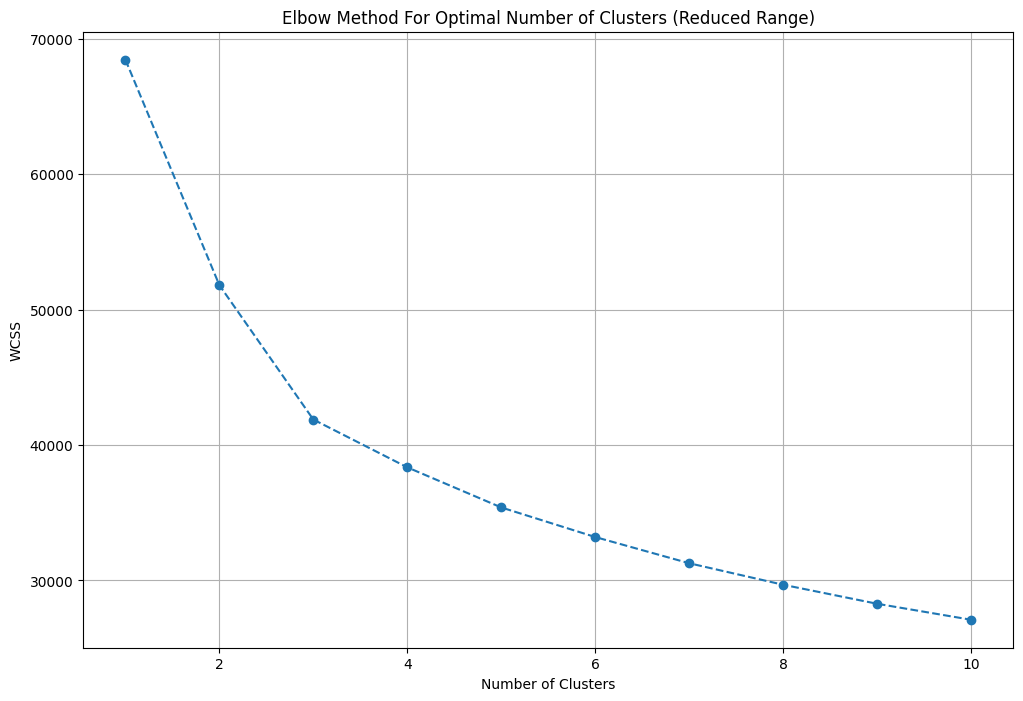

In [269]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [270]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [271]:
df = df.iloc[:,:-18]

In [273]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,ireo victory valley,sector 67,2.95,12110.0,2436.0,Super Built up area 2436(226.31 sq.m.)Built Up...,3,3,3+,"servant room,pooja room",14.0,South,Moderately Old,"['AIPL Joy Street Mall', 'Golf Course Extensio...","['3 Wardrobe', '15 Fan', '1 Exhaust Fan', '5 G...","['Water purifier', 'Centrally Air Conditioned'...",2436.0,2236.000000,2036.000000,0,1,0,1,0
1,house,independent,sector 54,5.50,38194.0,1440.0,Plot area 160(133.78 sq.m.),18,18,3+,servant room,4.0,South-West,Relatively New,"['Sector 54 chowk metro station', 'Sector metr...","['1 Water Purifier', '22 Fan', '1 Fridge', '1 ...","['Feng Shui / Vaastu Compliant', 'High Ceiling...",NaN,1440.000000,NaN,0,1,0,0,0
2,house,emaar mgf marbella,sector 66,NaN,NaN,NaN,Plot area 350(292.64 sq.m.)Built Up area: 6500...,4,4,3+,"pooja room,study room,servant room,store room",3.0,North,New Property,"['Sector 55-56 Rapid Metro Station', 'HUB 66',...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ...",NaN,6500.000000,NaN,1,1,1,1,0
3,house,sobha city,sector 108,10.50,14323.0,7331.0,Built Up area: 7331 (681.07 sq.m.),5,4,3+,not available,1.0,East,Undefined,"['Dwarka Sector 21', 'Dwarka Expressway', 'Vas...",NaN,NaN,NaN,7330.969373,NaN,0,0,0,0,0
4,flat,signature global grand iva,sector 103,0.30,8290.0,362.0,Carpet area: 361.88 (33.62 sq.m.),1,2,2,not available,5.0,NaN,New Property,"['Dwaraka Expy, Tikampur Village', 'Sector 108...",[],"['Security / Fire Alarm', 'Lift(s)', 'Maintena...",NaN,NaN,361.882318,0,0,0,0,0


In [274]:
df['furnishing_type'] = cluster_assignments

In [277]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1101,"['1 Exhaust Fan', '1 Stove', '1 Light', '1 AC'...",1
2707,"['1 Water Purifier', '5 Fan', '1 Exhaust Fan',...",0
1828,[],1
3389,"['2 Geyser', '1 Stove', '12 Light', '1 Modular...",0
1715,"['2 Wardrobe', '3 Fan', '15 Light', '1 Modular...",1


In [278]:
# features
df['features'].isnull().sum()

635

In [279]:
app_df = pd.read_excel('/content/real_estate_data.xlsx')
app_df.head(2)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
0,Smartworld One DXP,"2, 3, 4 BHK Apartment in Sector 113, Gurgaon","['Bajghera Road', 'Palam Vihar Halt', 'DPSG Pa...","{'Bajghera Road': '800 Meter', 'Palam Vihar Ha...",https://www.99acres.com/smartworld-one-dxp-sec...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Salon', 'Restaurant', 'Spa'..."
1,M3M Crown,"3, 4 BHK Apartment in Sector 111, Gurgaon","['DPSG Palam Vihar Gurugram', 'The NorthCap Un...","{'DPSG Palam Vihar Gurugram': '1.4 Km', 'The N...",https://www.99acres.com/m3m-crown-sector-111-g...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Mini Theatre', 'Manicured G..."


In [280]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [281]:
temp_df = df[df['features'].isnull()]

In [282]:
temp_df.shape

(635, 26)

In [284]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [285]:
df.loc[temp_df.index,'features'] = x.values

In [286]:
df['features'].isnull().sum()

481

In [287]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [288]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [289]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
1053,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
575,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0
1934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
3309,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [290]:
# Define the weights for each feature as provided
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [291]:
df['luxury_score'] = luxury_score

In [ ]:
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [295]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
687,flat,lotus elise,sector 99,0.95,6551.0,1450.0,Carpet area: 1450 (134.71 sq.m.),2,3,3,7.0,NaN,Relatively New,NaN,NaN,1450.004969,0,1,0,0,0,1,0.0
2385,flat,m3m merlin,sector 67,3.40,14418.0,2358.0,Super Built up area 2358(219.07 sq.m.)Carpet a...,3,4,3,16.0,North-West,Relatively New,2358.0,NaN,1708.000000,0,1,0,0,0,0,174.0
160,flat,raheja atharva,sector 109,2.20,9490.0,2318.0,Carpet area: 2318 (215.35 sq.m.),3,3,2,7.0,North,Moderately Old,NaN,NaN,2318.005865,0,1,0,0,0,0,111.0
370,house,independent,sector 43,3.35,26973.0,1242.0,Plot area 138(115.39 sq.m.),1,1,0,1.0,East,Old Property,NaN,1242.0,NaN,0,0,0,0,0,1,9.0
2990,flat,sare green parc phase 3,sector 92,0.75,7142.0,1050.0,Super Built up area 1326(123.19 sq.m.)Built Up...,3,2,2,3.0,East,New Property,1326.0,1298.0,1050.000000,0,0,0,0,0,1,121.0


In [296]:
df.to_csv('gurgaon_properties_cleaned_v2.csv',index=False)